# Introducing the Keras Sequential API

**Learning Objectives**
  1. Build a DNN model using the Keras Sequential API
  1. Learn how to train a model with Keras
  1. Learn how to save/load, and deploy a Keras model on GCP
  1. Learn how to deploy and make predictions with the Keras model

## Introduction

The [Keras sequential API](https://keras.io/models/sequential/) allows you to create Tensorflow models layer-by-layer. This is useful for building most kinds of machine learning models but it does not allow you to create models that share layers, re-use layers or have multiple inputs or outputs. 

In this lab, we'll see how to build a simple deep neural network model using the Keras sequential api. Once we have trained our model, we will deploy it using Vertex AI and see how to call our model for online prediciton.


Start by importing the necessary libraries for this lab.

In [1]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import aiplatform
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

print(tf.__version__)
%matplotlib inline

2.6.5


## Load raw data

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence. Those files have been saved into `../data`.

In [2]:
!ls -l ../data/*.csv

-rw-r--r-- 1 jupyter jupyter 123590 Jul 11 18:42 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 579055 Jul 11 18:42 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 123114 Jul 11 18:42 ../data/taxi-valid.csv


In [3]:
!head ../data/taxi*.csv

==> ../data/taxi-test.csv <==
6.0,2013-03-27 03:35:00 UTC,-73.977672,40.784052,-73.965332,40.801025,2,0
19.3,2012-05-10 18:43:16 UTC,-73.954366,40.778924,-74.004094,40.723104,1,1
7.5,2014-05-20 23:09:00 UTC,-73.999165,40.738377,-74.003473,40.723862,2,2
12.5,2015-02-23 19:51:31 UTC,-73.9652099609375,40.76948165893555,-73.98949432373047,40.739742279052734,1,3
10.9,2011-03-19 03:32:00 UTC,-73.99259,40.742957,-73.989908,40.711053,1,4
7.0,2012-09-18 12:51:11 UTC,-73.971195,40.751566,-73.975922,40.756361,1,5
19.0,2014-05-20 23:09:00 UTC,-73.998392,40.74517,-73.939845,40.74908,1,6
8.9,2012-07-18 08:46:08 UTC,-73.997638,40.756541,-73.973303,40.762019,1,7
4.5,2010-07-11 20:39:08 UTC,-73.976738,40.751321,-73.986671,40.74883,1,8
7.0,2013-12-12 02:16:40 UTC,-73.985024,40.767537,-73.981273,40.779302,1,9

==> ../data/taxi-train.csv <==
11.3,2011-01-28 20:42:59 UTC,-73.999022,40.739146,-73.990369,40.717866,1,0
7.7,2011-06-27 04:28:06 UTC,-73.987443,40.729221,-73.979013,40.758641,1,1
10.5,2011-04-03 0

## Use tf.data to read the CSV files

We wrote these functions for reading data from the csv files above in the [previous notebook](./2a_dataset_api.ipynb).

In [4]:
def parse_csv(row):
    ds = tf.strings.split(row, ",")
    label = tf.strings.to_number(ds[0])
    features = tf.strings.to_number(
        ds[2:6]
    )  # return pickup and drop off location only
    return features, label


def create_dataset(pattern, batch_size):
    ds = tf.data.TextLineDataset(pattern)
    ds = ds.map(parse_csv).batch(batch_size)
    return ds

## Build a simple keras DNN model

Next, we create the DNN model. The Sequential model is a linear stack of layers and when building a model using the Sequential API, you configure each layer of the model in turn. Once all the layers have been added, you compile the model. 

In [5]:
# Build a keras DNN model using Sequential API
model = Sequential(
    [
        Dense(
            units=32, input_shape=(4,), activation="relu", name="input_layer"
        ),
        Dense(units=8, activation="relu", name="hidden"),
        Dense(units=1, activation="linear", name="output"),
    ]
)

2022-07-13 16:34:22.347078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-07-13 16:34:22.347136: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-13 16:34:22.347165: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hurb-asl): /proc/driver/nvidia/version does not exist
2022-07-13 16:34:22.347633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Next, to prepare the model for training, you must configure the learning process. This is done using the compile method. The compile method takes three arguments:

* An optimizer. This could be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the [Optimizer class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers).
* A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function from the [Losses class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses) (such as categorical_crossentropy or mse), or it can be a custom objective function.
* A list of metrics. For any machine learning problem you will want a set of metrics to evaluate your model. A metric could be the string identifier of an existing metric or a custom metric function.

We will add an additional custom metric called `rmse` to our list of metrics which will return the root mean square error. 

In [6]:
# Create a custom evalution metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Compile the keras model
model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

## Train the model

To train your model, Keras provides two functions that can be used:
 1. `.fit()` for training a model for a fixed number of epochs (iterations on a dataset).
 2. `.train_on_batch()` runs a single gradient update on a single batch of data. 
 
The `.fit()` function works for various formats of data such as Numpy array, list of Tensors tf.data and Python generators. The `.train_on_batch()` method is for more fine-grained control over training and accepts only a single batch of data.

Our `create_dataset` function above generates batches of training examples, so we can use `.fit`. 

We start by setting up some parameters for our training job and create the data generators for the training and validation data.


In [7]:
trainds = create_dataset(pattern="../data/taxi-train.csv", batch_size=32)

evalds = create_dataset(pattern="../data/taxi-valid.csv", batch_size=32)

There are various arguments you can set when calling the [.fit method](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit). Here `x` specifies the input data which in our case is a `tf.data` dataset returning a tuple of (inputs, targets). The `steps_per_epoch` parameter is used to mark the end of training for a single epoch. Here we are training for NUM_EVALS epochs. Lastly, for the `callback` argument we specify a Tensorboard callback so we can inspect Tensorboard after training. 

In [8]:
%%time

LOGDIR = "./taxi_trained"
history = model.fit(
    x=trainds,
    epochs=10,
    validation_data=evalds,
    callbacks=[TensorBoard(LOGDIR)],
)

2022-07-13 16:34:32.510096: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-13 16:34:32.510169: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-07-13 16:34:32.511664: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-13 16:34:32.540936: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
     71/Unknown - 1s 3ms/step - loss: 99.4489 - rmse: 9.4018 - mse: 99.4489  

2022-07-13 16:34:33.146081: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-13 16:34:33.146144: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-07-13 16:34:33.150700: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-13 16:34:33.153702: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-13 16:34:33.160008: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./taxi_trained/train/plugins/profile/2022_07_13_16_34_33

2022-07-13 16:34:33.163552: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./taxi_trained/train/plugins/profile/2022_07_13_16_34_33/hurb-asl.trace.json.gz
2022-07-13 16:34:33.167435: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./taxi_trained/train/plugins/profile/2022_07_13_16_34_33

202

230/230 [==============================] - 1s 4ms/step - loss: 98.7225 - rmse: 9.2683 - mse: 98.7225 - val_loss: 110.2197 - val_rmse: 9.7598 - val_mse: 110.2197
Epoch 2/10
230/230 [==============================] - 1s 3ms/step - loss: 95.9578 - rmse: 9.1424 - mse: 95.9578 - val_loss: 110.2202 - val_rmse: 9.7595 - val_mse: 110.2202
Epoch 3/10
230/230 [==============================] - 1s 3ms/step - loss: 95.9590 - rmse: 9.1419 - mse: 95.9590 - val_loss: 110.2205 - val_rmse: 9.7595 - val_mse: 110.2205
Epoch 4/10
230/230 [==============================] - 1s 3ms/step - loss: 95.9586 - rmse: 9.1418 - mse: 95.9586 - val_loss: 110.2204 - val_rmse: 9.7595 - val_mse: 110.2204
Epoch 5/10
230/230 [==============================] - 1s 3ms/step - loss: 95.9580 - rmse: 9.1419 - mse: 95.9580 - val_loss: 110.2201 - val_rmse: 9.7595 - val_mse: 110.2201
Epoch 6/10
230/230 [==============================] - 1s 3ms/step - loss: 95.9572 - rmse: 9.1420 - mse: 95.9572 - val_loss: 110.2196 - val_rmse: 9.7595

### High-level model evaluation

Once we've run data through the model, we can call `.summary()` on the model to get a high-level summary of our network. We can also plot the training and evaluation curves for the metrics we computed above. 

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 32)                160       
_________________________________________________________________
hidden (Dense)               (None, 8)                 264       
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


Running `.fit` (or `.fit_generator`) returns a History object which collects all the events recorded during training. Similar to Tensorboard, we can plot the training and validation curves for the model loss and rmse by accessing these elements of the History object.

<AxesSubplot:>

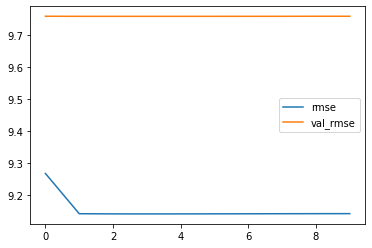

In [10]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

<AxesSubplot:>

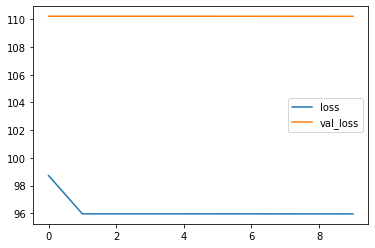

In [11]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot()

# Making predictions with our model

To make predictions with our trained model, we can call the [predict method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict), passing to it a dictionary of values. The `steps` parameter determines the total number of steps before declaring the prediction round finished. Here since we have just one example, we set `steps=1` (setting `steps=None` would also work). Note, however, that if x is a `tf.data` dataset or a dataset iterator, and steps is set to None, predict will run until the input dataset is exhausted.

In [12]:
model.predict([[-73.982683, 40.742104, -73.983766, 40.755174]])

array([[11.682316]], dtype=float32)

# Export and deploy our model

Of course, making individual predictions is not realistic, because we can't expect client code to have a model object in memory. For others to use our trained model, we'll have to export our model to a file, and expect client code to instantiate the model from that exported file. 

We'll export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

Next, print the signature of your saved model using the SavedModel Command Line Interface command `saved_model_cli`. You can read more about the command line interface and the `show` and `run` commands it supports in the [documentation here](https://www.tensorflow.org/guide/saved_model#overview_of_commands). 

In [13]:
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(OUTPUT_DIR, TIMESTAMP)

tf.saved_model.save(model, EXPORT_PATH)  # with default serving function

2022-07-13 16:42:51.395725: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./export/savedmodel/20220713164251/assets
INFO:tensorflow:Assets written to: ./export/savedmodel/20220713164251/assets


In [14]:
!saved_model_cli show \
    --tag_set serve \
    --signature_def serving_default \
    --dir {EXPORT_PATH}

!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 4)
      name: serving_default_input_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict
./export/savedmodel/20220713164251
./export/savedmodel/20220713164251/saved_model.pb
./export/savedmodel/20220713164251/variables
./export/savedmodel/20220713164251/variables/variables.index
./export/savedmodel/20220713164251/variables/variables.data-00000-of-00001
./export/savedmodel/20220713164251/assets


## Deploy our model to Vertex AI

Finally, we will deploy our trained model to Vertex AI and see how we can make online predicitons. 

In [15]:
PROJECT = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT = PROJECT[0]
BUCKET = PROJECT
REGION = "us-central1"
MODEL_DISPLAYNAME = f"taxifare-{TIMESTAMP}"

print(f"MODEL_DISPLAYNAME: {MODEL_DISPLAYNAME}")

# from https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest"
)

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

MODEL_DISPLAYNAME: taxifare-20220713164251


In [16]:
%%bash
# Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket exists, let's not recreate it."
else
    echo "Creating a new GCS bucket."
    gsutil mb -l ${REGION} gs://${BUCKET}
    echo "\nHere are your current buckets:"
    gsutil ls
fi

Bucket exists, let's not recreate it.


In [17]:
!gsutil cp -R $EXPORT_PATH gs://$BUCKET/$MODEL_DISPLAYNAME

Copying file://./export/savedmodel/20220713164251/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20220713164251/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20220713164251/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [3 files][100.4 KiB/100.4 KiB]                                                
Operation completed over 3 objects/100.4 KiB.                                    


In [19]:
uploaded_model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAYNAME,
    artifact_uri=f"gs://{BUCKET}/{MODEL_DISPLAYNAME}",
    serving_container_image_uri=SERVING_CONTAINER_IMAGE_URI,
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/464686547413/locations/us-central1/models/7590056309886550016/operations/4758611077187502080
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/464686547413/locations/us-central1/models/7590056309886550016
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/464686547413/locations/us-central1/models/7590056309886550016')


In [20]:
MACHINE_TYPE = "n1-standard-2"

endpoint = uploaded_model.deploy(
    machine_type=MACHINE_TYPE,
    accelerator_type=None,
    accelerator_count=None,
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/464686547413/locations/us-central1/endpoints/6144554761128509440/operations/529731027086606336
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/464686547413/locations/us-central1/endpoints/6144554761128509440
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/464686547413/locations/us-central1/endpoints/6144554761128509440')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/464686547413/locations/us-central1/endpoints/6144554761128509440
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/464686547413/locations/us-central1/endpoints/6144554761128509440/operations/1244677467931672576
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/464686547413

In [21]:
instance = {"input_layer_input": [-73.982683, 40.742104, -73.983766, 40.755174]}

In [22]:
endpoint.predict([instance])

Prediction(predictions=[[11.6823158]], deployed_model_id='6567871135868780544', explanations=None)

# Cleanup

When deploying a model to an endpoint for online prediction, the minimum `min-replica-count` is 1, and it is charged per node hour. So let's delete the endpoint to reduce unnecessary charges. Before we can delete the endpoint, we first undeploy all attached models... 

In [ ]:
endpoint.undeploy_all()

...then delete the endpoint.

In [ ]:
endpoint.delete()

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License